# Modelado y comparación de métodos de forecasting

Este notebook tiene como objetivo comparar distintos modelos de predicción de series de tiempo aplicados a las exportaciones físicas de cobre chileno. El análisis detallado se realiza sobre la serie `Total_TM`, correspondiente a la producción total exportada, y luego se replica el proceso más brevemente sobre las otras tres categorías.

Se compararán los siguientes modelos:
- Prophet (modelo estructural aditivo)
- ARIMA / SARIMA (modelo estadístico clásico)
- otros modelos avanzados como Holt-Winters, XGBoost

Se evaluará el rendimiento mediante métricas de error como MAE, RMSE y MAPE.


In [31]:
# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

from prophet.diagnostics import cross_validation, performance_metrics
from itertools import product
from pmdarima import auto_arima
import itertools

# Utilidades
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

import logging
import sys
# Reducir la verbosidad de cmdstanpy
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
# (Opcional) Silenciar Prophet también, si es que usa logging
logging.getLogger("prophet").setLevel(logging.WARNING)

# Configuración de gráficos
plt.rcParams["figure.figsize"] = (12,6)
sns.set(style="whitegrid")

In [2]:
# Carga de datos procesados
df_total = pd.read_csv("../data/processed/Total_TM.csv")
df_total['ds'] = pd.to_datetime(df_total['ds'])
df_total = df_total.sort_values('ds').reset_index(drop=True)

# Visualizar
df_total.tail()

,ds,y
263,2024-12-01,457.260742
264,2025-01-01,438.623474
265,2025-02-01,498.914429
266,2025-03-01,529.273804
267,2025-04-01,425.905640


## División de entrenamiento y prueba

Para evaluar los modelos, se separan los últimos 12 meses como conjunto de prueba (`test`), y el resto como entrenamiento (`train`). Esto permite medir la capacidad del modelo de predecir valores futuros que no ha visto.


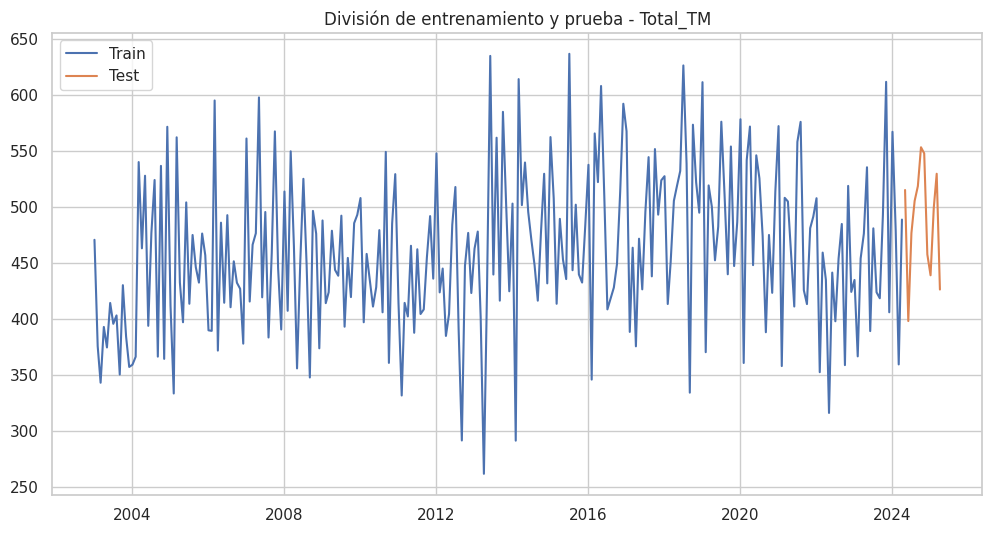

In [3]:
# Definir puntos de corte
train = df_total[:-12].copy()
test = df_total[-12:].copy()

# Visualizar
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')
plt.title("División de entrenamiento y prueba - Total_TM")
plt.legend()
plt.show()

## Modelo Prophet

Prophet es un modelo estructural aditivo que descompone la serie en componentes como tendencia, estacionalidad y efectos especiales. Es robusto, fácil de ajustar, y útil como línea base.

18:21:49 - cmdstanpy - INFO - Chain [1] start processing
18:21:49 - cmdstanpy - INFO - Chain [1] done processing


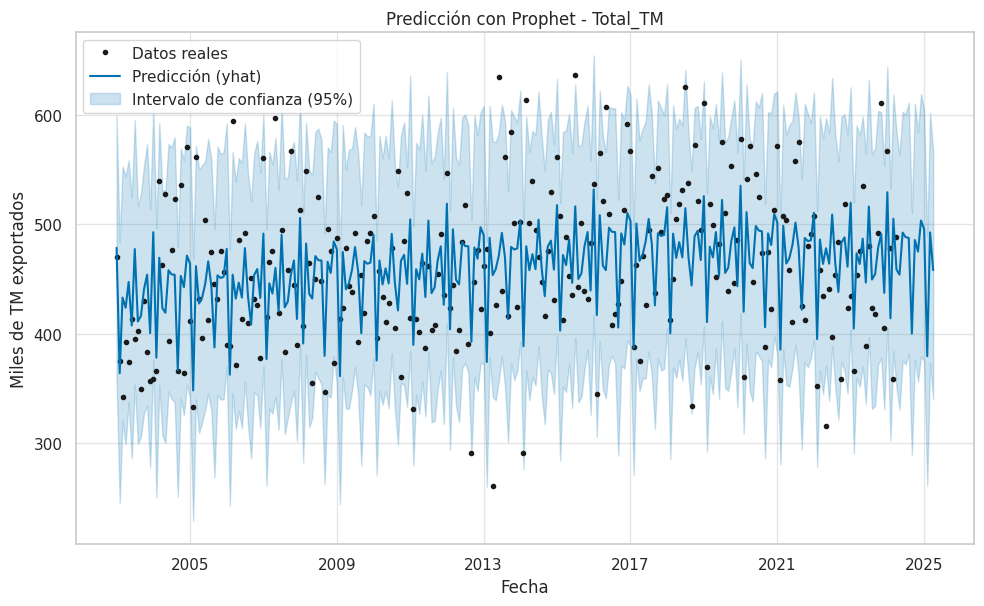

In [4]:
# Entrenar Prophet
model_prophet = Prophet(interval_width=0.95)
model_prophet.fit(train)

# Generar fechas futuras
future = model_prophet.make_future_dataframe(periods=12, freq='MS') # MS = Month Start
forecast = model_prophet.predict(future)

fig = model_prophet.plot(forecast)
plt.title("Predicción con Prophet - Total_TM")
plt.xlabel("Fecha")
plt.ylabel("Miles de TM exportados")

# Agregar leyenda explicativa
plt.legend(["Datos reales", "Predicción (yhat)", "Intervalo de confianza (95%)"])
plt.show()

> *El modelo estima que hay un 95% de probabilidad de que el valor real esté dentro de esta banda (Intervalo de confianza).*

In [5]:
# Extraer predicción del rango de test
forecast_test = forecast[['ds', 'yhat']].set_index('ds').loc[test['ds']]
test_eval = test.set_index('ds')

# Calcular métricas
def evaluar(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

mae_p, rmse_p, mape_p = evaluar(test_eval['y'], forecast_test['yhat'])

print(f"Prophet - MAE: {mae_p:.2f}, RMSE: {rmse_p:.2f}, MAPE: {mape_p:.2f}%")

Prophet - MAE: 61.17, RMSE: 70.00, MAPE: 12.61%


### Modelo Prophet y Optimización de hiperparámetros

**Hiperparámetros que probaremos**:
* **`changepoint_prior_scale`**: Controla cuán flexible es el modelo ante cambios de tendencia. Alto = más flexible, pero riesgo de sobreajuste.
(**Valores sugeridos**: `[0.001, 0.01, 0.1, 0.5]`)

* **`seasonality_mode`**: Tipo de estacionalidad. (**Valores**: `['additive', 'multiplicative']`)

In [6]:
# Definir grid de parámetros
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Crear combinaciones
all_params = [dict(zip(param_grid, v)) for v in product(*param_grid.values())]
all_params

[{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative'},
 {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'},
 {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'},
 {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}]

In [ ]:
results = []

for params in all_params:
    model = Prophet(**params)
    model.fit(train)
    
    # Validación cruzada con Prophet
    df_cv = cross_validation(model, initial='1095 days', period='180 days', horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    results.append({
        'params': params,
        'rmse': df_p['rmse'].mean()
    })

# Seleccionar mejor combinación
results_df = pd.DataFrame(results).sort_values(by='rmse')

In [13]:
results_df

,params,rmse
4,"{'changepoint_prior_scale': 0.1, 'seasonality_...",68.708748
2,"{'changepoint_prior_scale': 0.01, 'seasonality...",68.887620
5,"{'changepoint_prior_scale': 0.1, 'seasonality_...",69.177203
6,"{'changepoint_prior_scale': 0.5, 'seasonality_...",69.321124
3,"{'changepoint_prior_scale': 0.01, 'seasonality...",69.480320
7,"{'changepoint_prior_scale': 0.5, 'seasonality_...",69.702194
0,"{'changepoint_prior_scale': 0.001, 'seasonalit...",72.760097
1,"{'changepoint_prior_scale': 0.001, 'seasonalit...",73.706520


> Se realizó una búsqueda de hiperparámetros para el modelo Prophet con el fin de mejorar su desempeño predictivo.
La mejor configuración encontrada fue **`changepoint_prior_scale`** = `0.1` y **`seasonality_mode`** = `'additive'`, la cual obtuvo un **RMSE promedio de 68.71 en validación cruzada** sobre la serie de exportaciones totales de cobre.

## Modelo ARIMA

ARIMA es un modelo estadístico clásico que combina autorregresión (AR), diferenciación (I), y media móvil (MA). Es útil para series estacionarias o suavemente no estacionarias.


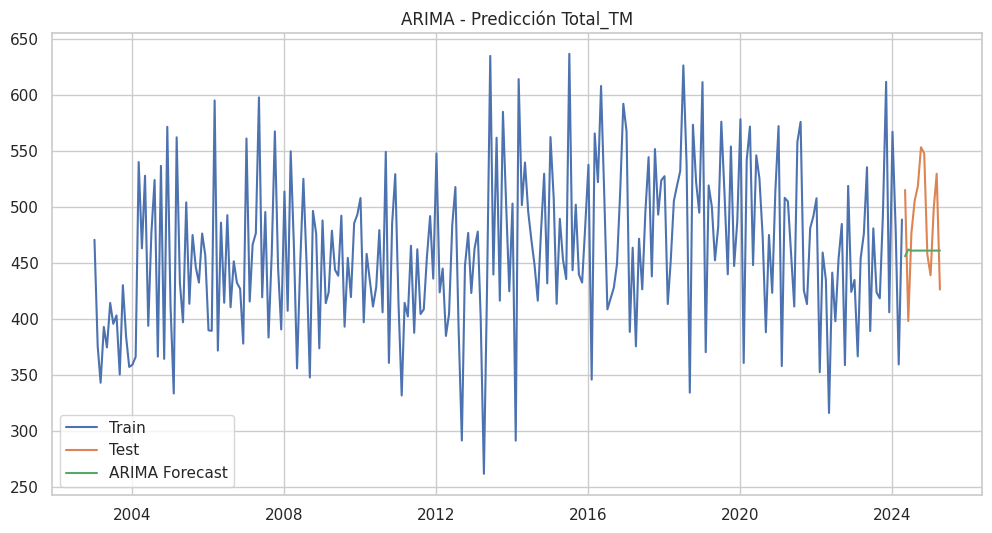

ARIMA - MAE: 48.89, RMSE: 55.54, MAPE: nan%


In [8]:
# Ajustar modelo ARIMA(p,d,q) - Ejemplo base (puedes ajustar después con auto_arima)
arima_model = ARIMA(train['y'], order=(1,1,1))
arima_fit = arima_model.fit()

# Predicción
arima_forecast = arima_fit.forecast(steps=12)
arima_forecast.index = test['ds']

# Visualizar
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')
plt.plot(test['ds'], arima_forecast, label='ARIMA Forecast')
plt.title("ARIMA - Predicción Total_TM")
plt.legend()
plt.show()

# Métricas
mae_a, rmse_a, mape_a = evaluar(test['y'], arima_forecast)
print(f"ARIMA - MAE: {mae_a:.2f}, RMSE: {rmse_a:.2f}, MAPE: {mape_a:.2f}%")

### Modelo ARIMA y Optimización de hiperparámetros

El modelo ARIMA se define por tres valores clave: (p, d, q), que representan lo siguiente:
* **`p`**: Autoregressive (AR), Número de valores pasados que el modelo usa como input
* **`d`**: Differencing, Número de veces que se diferencia la serie para hacerla estacionaria
* **`q`**: Moving Average (MA), Número de términos de medias móviles (errores pasados) que se usan para ajustar el modelo

In [15]:
modelo_auto = auto_arima(
    train['y'], 
    seasonal=False,       # Puedes probar True si crees que hay estacionalidad
    trace=True,           # Muestra el proceso
    stepwise=True,        # Para acelerar
    suppress_warnings=True,
    error_action="ignore"
)

# Ajuste final y predicción
modelo_auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2884.348, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3086.383, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2991.695, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2888.094, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3084.383, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2881.946, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2881.393, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2882.493, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2882.520, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2884.252, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2879.922, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2886.687, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2880.487, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2881.034, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  256
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1436.961
Date:                Thu, 03 Jul 2025   AIC                           2879.922
Time:                        18:27:07   BIC                           2890.545
Sample:                             0   HQIC                          2884.195
                                - 256                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1319      0.065    -17.501      0.000      -1.259      -1.005
ma.L2          0.2007      0.064      3.155      0.002       0.076       0.325
sigma2      4553.9026    389.062     11.705      0.000    3791.356    5316.450
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.91   Prob(JB):                         0.62
Heteroskedasticity (H):               1.25   Skew:                             0.13
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

> Se utilizó la función auto_arima para encontrar automáticamente la mejor configuración de hiperparámetros (p,d,q) **para el modelo ARIMA.
El mejor modelo encontrado fue ARIMA(0,1,2)**, lo que indica que la serie necesita una diferenciación para volverse estacionaria (d=1), y que la predicción se realiza en función de los errores de los dos periodos anteriores (q=2).

> Este modelo obtuvo un AIC de 2879.9, siendo el más bajo entre todas las combinaciones evaluadas.

## Modelo Holt-Winters (Exponential Smoothing)

Modelo clásico que considera tendencia y estacionalidad con componentes exponenciales.

In [24]:
# Ajustar el modelo sobre la serie de entrenamiento
model_hw = ExponentialSmoothing(train['y'], trend='add', seasonal='add', seasonal_periods=12)
fitted_hw = model_hw.fit()

# Predecir sobre el conjunto de test
forecast_hw = fitted_hw.forecast(len(test))

# Calcular métrica
rmse_hw = mean_squared_error(test['y'], forecast_hw, squared=False)

In [25]:
rmse_hw

68.6917444325155

### Modelo Holt-Winters (Exponential Smoothing) y Optimización de hiperparámetros


In [32]:
# Definir los parámetros posibles
trend_options = ['add', 'mul', None]
seasonal_options = ['add', 'mul', None]
seasonal_periods = 12

# Guardar resultados
results_hw = []

for trend, seasonal in itertools.product(trend_options, seasonal_options):
    if trend is None and seasonal is None:
        continue  # ignorar modelo trivial
    
    try:
        model = ExponentialSmoothing(
            train['y'],
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=seasonal_periods
        )
        fitted = model.fit()
        forecast = fitted.forecast(len(test))
        rmse = mean_squared_error(test['y'], forecast, squared=False)
        results_hw.append({
            'trend': trend,
            'seasonal': seasonal,
            'rmse': rmse
        })
    except:
        continue  # ignorar errores por combinaciones no válidas

# Mostrar mejor resultado
best_hw = sorted(results_hw, key=lambda x: x['rmse'])[0]
print(f"Mejor configuración Holt-Winters: {best_hw}")

Mejor configuración Holt-Winters: {'trend': 'mul', 'seasonal': None, 'rmse': 58.310608779821855}


## Modelo XGBoost para series temporales

In [28]:
def create_features(df, lags=12):
    df = df.copy()
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df['y'].shift(i)
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    return df.dropna()

In [33]:
full_series = train[['ds', 'y']].copy()
data = create_features(full_series)  # full_series = serie completa
X = data.drop(columns=['ds', 'y'])
y = data['y']

# TimeSeriesSplit respeta el orden temporal
tscv = TimeSeriesSplit(n_splits=5)

model = xgb.XGBRegressor()

param_grid = {
    'max_depth': [2, 3, 4],
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1, 0.2]
}

grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search.fit(X, y)

best_model = grid_search.best_estimator_

In [34]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

## Comparacion de resultados

In [9]:
# Crear tabla de resultados
resultados = pd.DataFrame({
    'Modelo': ['Prophet', 'ARIMA'],
    'MAE': [mae_p, mae_a],
    'RMSE': [rmse_p, rmse_a],
    'MAPE (%)': [mape_p, mape_a]
})

resultados.set_index('Modelo', inplace=True)
resultados

,MAE,RMSE,MAPE (%)
Modelo,,,
Prophet,61.168209,69.995798,12.608063
ARIMA,48.893565,55.544267,NaN
